In [ ]:
! pip install faiss-cpu

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.7/30.7 MB 47.5 MB/s eta 0:00:00


In [ ]:
from tqdm import tqdm, tnrange, tqdm_notebook
import numpy as np
import os, sys
import matplotlib.pyplot as plt
import pickle
import json
import gdown
import h5py
import faiss

%matplotlib inline

# Seminar: kNN index and trees

## kNN indices

### 1. Load embeddings

In [ ]:
file_id = '1-1t1sbQXXyB-qZr-czqv2UJ4E5BQ7McI'
destination = 'lastftm_factors.h5'
download_url = f"https://drive.google.com/uc?id={file_id}"

gdown.download(download_url, destination, quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=1-1t1sbQXXyB-qZr-czqv2UJ4E5BQ7McI
From (redirected): https://drive.google.com/uc?id=1-1t1sbQXXyB-qZr-czqv2UJ4E5BQ7McI&confirm=t&uuid=f8f42362-af6f-4ffc-8b53-0d7426bfca17
To: /content/lastftm_factors.h5
100%|██████████| 333M/333M [00:06<00:00, 55.3MB/s]


'lastftm_factors.h5'

In [ ]:
h5f = h5py.File('/content/lastftm_factors.h5', 'r')
item_factors = h5f['items'][:]
user_factors = h5f['users'][:]
h5f.close()

In [ ]:
item_factors.shape

(292385, 128)

In [ ]:
user_factors.shape

(358868, 128)

### 2. Neighbours search with FAISS

[Faiss docs](https://faiss.ai/)

In [ ]:
%%time
ip_index = faiss.IndexFlatIP(item_factors.shape[1]) # Create index Exact Search for Inner Product

ip_index.add(item_factors) # Add document embeddings to index
print(ip_index.ntotal)

292385
CPU times: user 48.7 ms, sys: 77.1 ms, total: 126 ms
Wall time: 124 ms


In [ ]:
k = 10  # Choose  10 nearest neighbours
n_users = 100  # 1000 users is real example of request batch

user_embeddings = user_factors[:n_users]

In [ ]:
%%timeit
# D - distances
# I - indices
dist_brute, index_brute = ip_index.search(user_embeddings, k)

209 ms ± 9.08 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
dist_brute, index_brute = ip_index.search(user_embeddings, k)

In [ ]:
dist_brute

array([[1.1410543 , 1.1322321 , 1.1187365 , 1.0928438 , 1.0664618 ,
        1.062733  , 1.05291   , 1.0320057 , 1.0301973 , 1.0179089 ],
       [1.2508918 , 1.249527  , 1.2257144 , 1.2112938 , 1.1923635 ,
        1.189894  , 1.1788456 , 1.1644775 , 1.1519464 , 1.1518093 ],
       [1.2452835 , 1.1997979 , 1.1582257 , 1.1489418 , 1.1402626 ,
        1.1235999 , 1.1207418 , 1.1171805 , 1.1170992 , 1.1122485 ],
       [0.2779214 , 0.27696735, 0.274095  , 0.2529633 , 0.25276822,
        0.25211608, 0.25108036, 0.25066024, 0.2502004 , 0.24998583],
       [0.93591565, 0.9298431 , 0.9099228 , 0.9058028 , 0.8849318 ,
        0.8814032 , 0.8721441 , 0.87095225, 0.86844033, 0.8438685 ],
       [1.104717  , 1.019489  , 0.9971459 , 0.9953436 , 0.9865202 ,
        0.9826387 , 0.98047775, 0.97209066, 0.9599873 , 0.9564393 ],
       [0.7837306 , 0.7463593 , 0.7397743 , 0.7323941 , 0.7101607 ,
        0.7073074 , 0.70373976, 0.6998372 , 0.69758344, 0.6970285 ],
       [0.9136187 , 0.8925763 , 0.8865918

In [ ]:
index_brute

array([[150177, 161850, 107119, 144310,  76757, 255141, 155259,  46258,
        136336, 259874],
       [186566,  86649,  71465,  78295, 229823,  54967, 189597, 252956,
        250342, 267949],
       [180940, 142885, 120981,  37629,  78810, 166647, 159270, 234769,
        241312, 186835],
       [ 22260, 204354,  83064,  22175, 106705, 205071, 197976, 110375,
        141812, 108361],
       [214788, 245454,  80459, 117781, 253132,  62539, 279640,  72927,
         99079,  51575],
       [167801, 155806,  41524, 137221, 271902, 136548,   2153,  96069,
        235589, 252221],
       [242144, 163357, 191070, 108652,  68167, 239279, 161466, 276474,
        161884, 168440],
       [228750, 160992,  20361,  48726,  43254,  38706, 157961, 114007,
          6824, 225860],
       [ 62883, 165635, 104763, 106310,  17588, 165564, 185338,  84217,
        104154, 105142],
       [261239, 209807, 138496, 206058,  52976, 225156, 261380, 215327,
        170961, 260396],
       [159630, 138644, 266575

Let's compare with vanilla method to find nearest neighbours:

In [ ]:
# too long because we sort full array
product = user_embeddings.dot(item_factors.T)
exact_indexes = np.argsort(product, axis=1)[:,:-k-1:-1]

In [ ]:
%%time
product = user_embeddings.dot(item_factors.T)
neighbours = np.partition(-1 * product, k, axis=1)[:, :k]
exact_distances = -1 * np.sort(neighbours, axis=1)

CPU times: user 561 ms, sys: 244 ms, total: 805 ms
Wall time: 547 ms


In [ ]:
np.allclose(dist_brute, exact_distances)

True

In [ ]:
np.equal(index_brute, exact_indexes).mean()

1.0

### 3. HNSW

<img src="https://drive.google.com/uc?export=view&id=1CZlsisey6UWP5rccRE2QaLuInIUkCM2J" width="500">



**HNSW** (Hierarchical navigable small world) - graph-based approximate nearest neighbor algorithm.

In [ ]:
%%time
neighbours = 10
hnsw_index = faiss.IndexHNSWFlat(item_factors.shape[1], neighbours, faiss.METRIC_INNER_PRODUCT) # Create HNSW index

hnsw_index.add(item_factors) # Add document embeddings to index
print(hnsw_index.ntotal)

292385
CPU times: user 20 s, sys: 254 ms, total: 20.3 s
Wall time: 12.1 s


In [ ]:
%%time
dist_hnsw, index_hnsw = hnsw_index.search(user_embeddings, k)

CPU times: user 9.92 ms, sys: 0 ns, total: 9.92 ms
Wall time: 6.81 ms


In [ ]:
index_hnsw

array([[199859, 247960, 212985, 254550, 152322, 214322, 220146,  66298,
        138863, 169193],
       [252512, 185535, 118839, 240761, 155888, 230297, 127940,  76604,
          1921, 246378],
       [204727, 159951,   4486, 130425, 265240,  82437, 281570, 235136,
        207283, 210818],
       [201378,  26083,  49113, 197795,  33475, 259760, 199232, 121893,
        202627, 204686],
       [119589,  75648, 162314, 174373,   1384, 194867,  64947,  65130,
        261228, 252512],
       [ 51575, 217901,  42098, 235136, 261239, 269180,  94794, 147899,
        113468, 194180],
       [247960, 220146, 212514, 194180, 199859, 187028,   5653, 152322,
         73871, 252512],
       [187028, 254550,   5653,  73871, 212985, 212514, 209377, 220146,
         13811, 235136],
       [ 62883, 197548, 179147,  28558, 173846, 176817, 111880,  82690,
        234959, 275193],
       [261239, 247960,   5653,  96710, 220146, 199859, 102350, 127243,
         80500, 212985],
       [ 73871, 212985, 156648

In [ ]:
dist_hnsw

array([[0.61775047, 0.5910607 , 0.54134333, 0.35557497, 0.28553063,
        0.283923  , 0.25522143, 0.22882897, 0.16868529, 0.15287608],
       [0.8348808 , 0.81974405, 0.67940515, 0.60749865, 0.49130064,
        0.48271075, 0.3862294 , 0.22748037, 0.22179717, 0.20787638],
       [0.7008995 , 0.55742735, 0.5514311 , 0.38680217, 0.3696531 ,
        0.32953644, 0.30533308, 0.28922236, 0.28634757, 0.27511612],
       [0.22992712, 0.16495621, 0.12978938, 0.12655655, 0.11951543,
        0.11905906, 0.11633296, 0.11382075, 0.11049715, 0.09509384],
       [0.4809711 , 0.46014208, 0.44205087, 0.34051946, 0.3313798 ,
        0.3194845 , 0.24709998, 0.24205282, 0.21280944, 0.19285487],
       [0.8361938 , 0.79104114, 0.74960864, 0.66761893, 0.5540648 ,
        0.45833188, 0.45825738, 0.4576605 , 0.41616765, 0.37435108],
       [0.53642976, 0.4062492 , 0.35317835, 0.26930404, 0.2659005 ,
        0.2328097 , 0.21301389, 0.18929267, 0.18564144, 0.18179038],
       [0.6089469 , 0.37130743, 0.3168042

In [ ]:
np.equal(index_hnsw, exact_indexes).mean()

0.004

Algorithm is not tuned for the dataset, so results are poor. But you can find optimal parameters for 99% or even 99.9%.

## Trees

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeRegressor

%matplotlib inline

### Regression task

Let's generate dataset:

In [ ]:
rng = np.random.RandomState(1)
X = np.sort(5 * rng.rand(80, 1), axis=0)
y = np.sin(X).ravel()
y[::5] += 3 * (0.5 - rng.rand(16))

And train model:

In [ ]:
regr = DecisionTreeRegressor(max_depth=2)
regr.fit(X, y)

DecisionTreeRegressor(max_depth=2)

Prediction:

In [ ]:
X_test = np.arange(0.0, 5.0, 0.01)[:, np.newaxis]
y_pred = regr.predict(X_test)

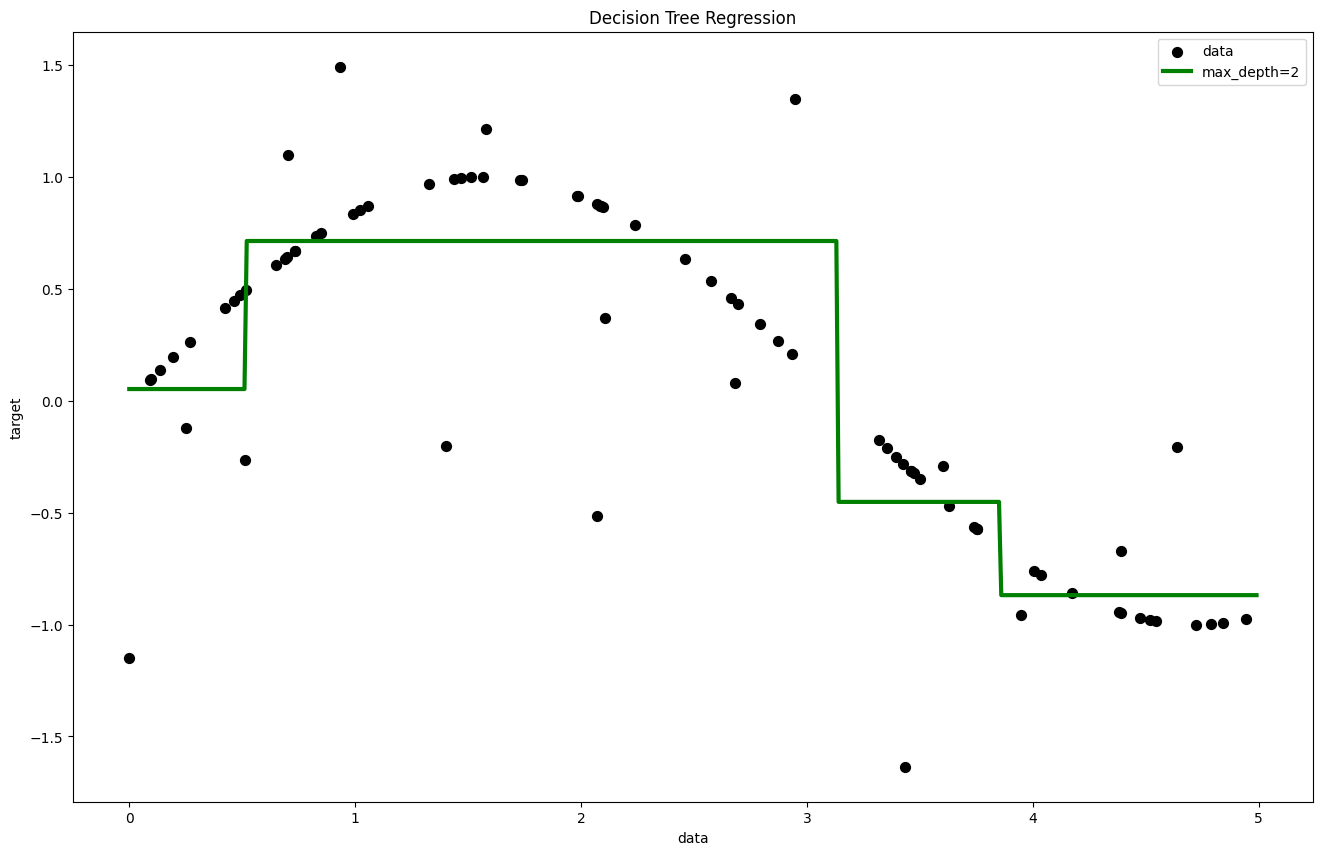

In [ ]:
plt.figure(figsize=(16, 10))

plt.scatter(X, y, s=50, color="black", label="data")
plt.plot(X_test, y_pred, color="green", label="max_depth=2", linewidth=3)

plt.xlabel("data")
plt.ylabel("target")
plt.title("Decision Tree Regression")
plt.legend()
plt.show()

You can look at nice visualization here: http://www.r2d3.us/visual-intro-to-machine-learning-part-1/

### Constructing trees

* Train sample $(x_i,y_i)_{i=1}^l\in X \times Y$
* How to split in two: $R_1(j,s)=\{x|x_j \leq s\}$ и $R_2(j,s) = \{x | x_j > s \}$ using Q(X, j, s)?

Find the best values of $j$ and $s$, create the root node of the tree by putting the function (predicate) $[x_j \leq s ]$ in correspondence with it. The sample objects will be split into two parts and will fall into either the left or right subtree. We continue this procedure for each sub-sample. If after the next partitioning one of the halves contains objects of one of the classes, we will create a leaf node that corresponds to the class of the objects in it.

### Information criteria

* $R_m$ is the set of objects of the training sample falling into vertex $m$,
* $N_m=|R_m|$.
* $p_{mk}$ is the fraction of objects of class $k\in\{1, ..., K\}$ that hit the vertex $m$: $p_{mk}=\frac{1}{N_m} \sum\limits_{x_i\in R_m} [y_i = k]$.
* $k_m = arg \max\limits_{k} p_{mk}$ is the class whose representatives are the most numerous among the objects that hit the vertex $m$.

### 1. Classification error

If vertex $m$ were a leaf and assigned all objects to class $k$:

$$
H(R_m) = \frac{1}{N_m} \sum\sum\limits_{x_i \in R_m} [y_i \neq k_m].
$$

Informativity criterion for branching of vertex $m$: ($l$ and $r$ are right and left vertices)

$$
Q(R_m, j, s) = H (R_m) - \frac{N_l}{N_m} H(R_l) - \frac{N_r}{N_m} H(R_r) \to \max\limits_{j, s}
$$

Coarse criterion - considers the frequency $p_{m, k_m}$ of only one class

#### Problem 1
Show that the classification error can also be written as
$$H(R_m) = 1 - p_{m, k_m}$$

#### Solution    
$$
1 = \frac{1}{N_m}\sum_{(x_i,\,y_i) \in R_m}[y_i \neq k_m] + \frac{1}{N_m}\sum_{(x_i,\,y_i) \in R_m}[y_i = k_m]
$$
$$
H(R_m) = \frac{1}{N_m}\sum_{(x_i,\,y_i) \in R_m}[y_i \neq k_m] = 1 - p_{m, k_m}
$$

#### Problem 2

Show that the Gini index $H(R_m)$ can also be written in the form:

$$H(R_m) = \sum_{k = 1}^{K} p_{mk} (1 - p_{mk}) = 1 - \sum_{k = 1}^K p_{mk}^2$$

#### Solution

$$
        \sum_{k \neq k'} p_{mk} p_{mk'}
        =
        \sum_{k = 1}^{K} p_{mk} \sum_{k' \neq k} p_{mk'}
        =
        \sum_{k = 1}^{K} p_{mk} (1 - p_{mk}).
$$

### 3. Entropy criterion (Shannon criterion)
Consider a discrete random variable,
taking $K$ values with probabilities $p_1, \dots, p_K$
respectively.
*** The entropy *** of this random variable is defined as:
$$H(p) = -\sum_{k = 1}^{K} p_k \log_2 p_k$$

#### Problem 3
Show that the entropy is bounded from above and reaches its maximum on the
uniform distribution $p_1 = \dots = p_K = 1/K$.

#### Solution

We need Jensen's inequality: for any concave function $f$
is satisfied
$$
    f\left(\sum_{i = 1}^{n} a_i x_i\right) \geq \sum_{i = 1}^{n} a_i f(x_i),
$$
if $\sum_{i = 1}^{n} a_i = 1$.

Let's apply it to the logarithm in the definition of entropy~(it is a concave function):
$$
H(p) = \sum_{k = 1}^{K} p_k \log_2 \frac{1}{p_k}
\leq \log_2 \left( \sum_{k = 1}^{K} p_i \frac{1}{p_i} \right)=\log_2 K.
$$

Finally, let's find the entropy of the uniform distribution:
$$
-\sum_{k = 1}^{K} \frac{1}{K} \log_2 \frac{1}{K} = - K \frac{1}{K} \log_2 \frac{1}{K} = \log_2 K.
$$

The entropy is bounded from below by zero, and the minimum is achieved on degenerate
distributions ($p_i = 1$, $p_j = 0$ for $i \neq j$).

The entropic informativeness criterion is defined as
$$
    Q(R_m, j, s) = H(p_m) - \frac{N_\ell}{N_m} H(p_\ell) - \frac{N_r}{N_m} H(p_r),
$$
where $p_i = (p_{i1}, \dots, p_{iK})$ is the distribution of classes in the $i$-th vertex.
It can be seen that this criterion favors more “degenerate” class distributions
of classes.

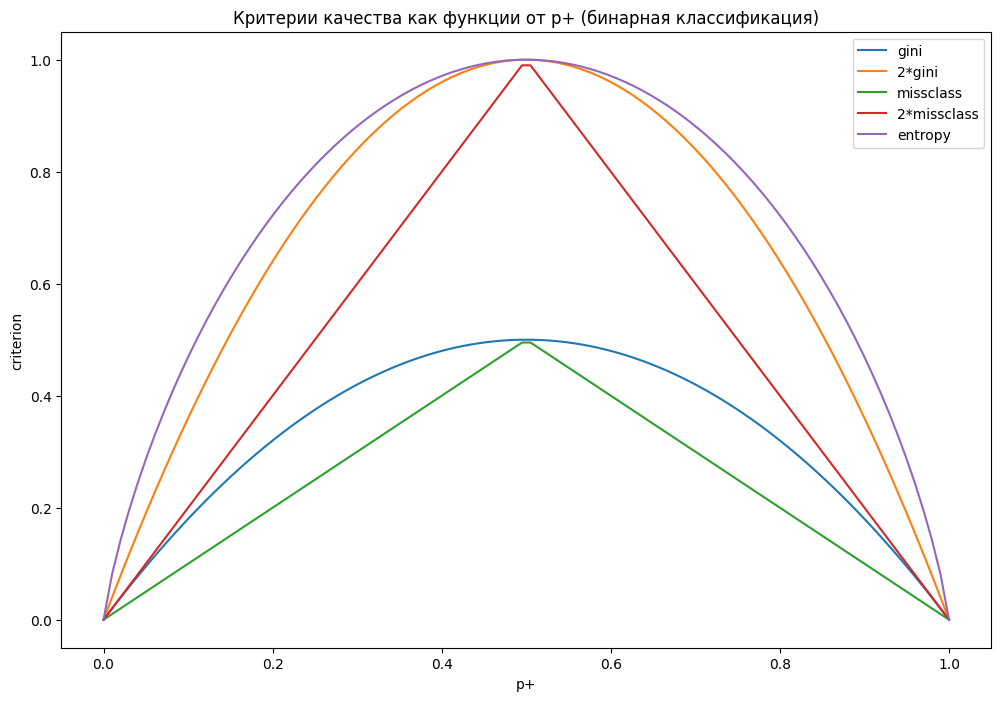

In [ ]:
plt.figure(figsize=(12, 8))

p = np.linspace(0, 1, 100)

plt.plot(p, [2 * x * (1-x) for x in p], label='gini')
plt.plot(p, [4 * x * (1-x) for x in p], label='2*gini')
plt.plot(p, [1 - max(x, 1 - x) for x in p], label='missclass')
plt.plot(p, [2 * (1 - max(x, 1 - x)) for x in p], label='2*missclass')
plt.plot(p, [-x * np.log2(x + 1e-10) - (1 - x) * np.log2(1 - x + 1e-10) for x in p], label='entropy')

plt.xlabel('p+')
plt.ylabel('criterion')
plt.title('Критерии качества как функции от p+ (бинарная классификация)')
plt.legend()
plt.show()

## 4. Criteria in regression problems
In regression problems, the variance of responses in a worksheet is usually chosen as a criterion:
$$
H_R(R_m) = \frac{1}{N_m} \sum_{(x_i,\,y_i) \in R_m} \left(y_i-\frac{1}{N_m}\sum_{(x_i,\,y_i) \in R_m} y_j \right)^2.
$$
Other criteria can be used, such as the mean absolute deviation from the median.

## Criterion for stopping tree construction

For any consistent training sample, we can construct a decision tree that has zero error on the given sample. If we consider objects as points in feature space, then each point can be restricted to an n-dimensional cube that contains no other points. The n-dimensional cube can be perfectly defined by a tree.

 However, in this case **overfitting** takes place.

This raises the question: in what case should a vertex be declared a leaf vertex?

Let us consider a model regression problem. The objects will be points on the plane (i.e. each object is described by 2 features), the target variable is the distance from the object to the point (0, 0).

In [ ]:
def get_grid(data):
    x_min, x_max = data[:, 0].min() - 1, data[:, 0].max() + 1
    y_min, y_max = data[:, 1].min() - 1, data[:, 1].max() + 1
    return np.meshgrid(
        np.arange(x_min, x_max, 0.01),
        np.arange(y_min, y_max, 0.01),
    )

Let's generate dataset:

In [ ]:
data_x = np.random.normal(size=(100, 2))
data_y = (data_x[:, 0] ** 2 + data_x[:, 1] ** 2) ** 0.5

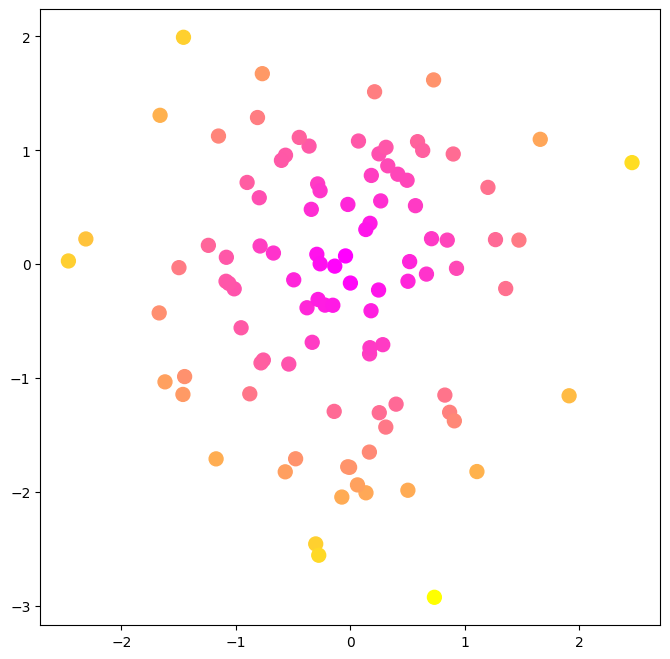

In [ ]:
plt.figure(figsize=(8, 8))
plt.scatter(data_x[:, 0], data_x[:, 1], c=data_y, s=100, cmap='spring')

And train regressor:

In [ ]:
clf = DecisionTreeRegressor()
clf.fit(data_x, data_y)

DecisionTreeRegressor()

Let's look at predictions:

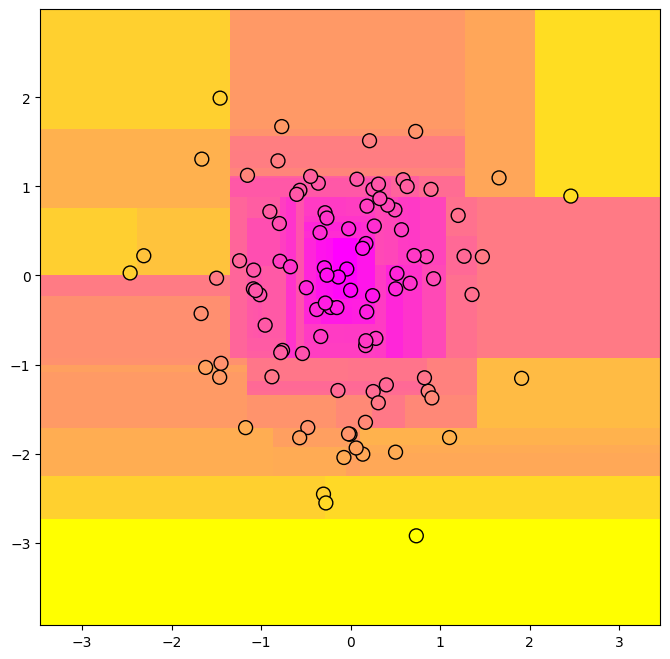

In [ ]:
xx, yy = get_grid(data_x)

predicted = clf.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

plt.figure(figsize=(8, 8))
plt.pcolormesh(xx, yy, predicted, cmap='spring')
plt.scatter(data_x[:, 0], data_x[:, 1], c=data_y, s=100, cmap='spring', edgecolor='k')

Let's see how the division of the plane will look like depending on the
- minimum number of objects in the leaf
- maximum tree depth

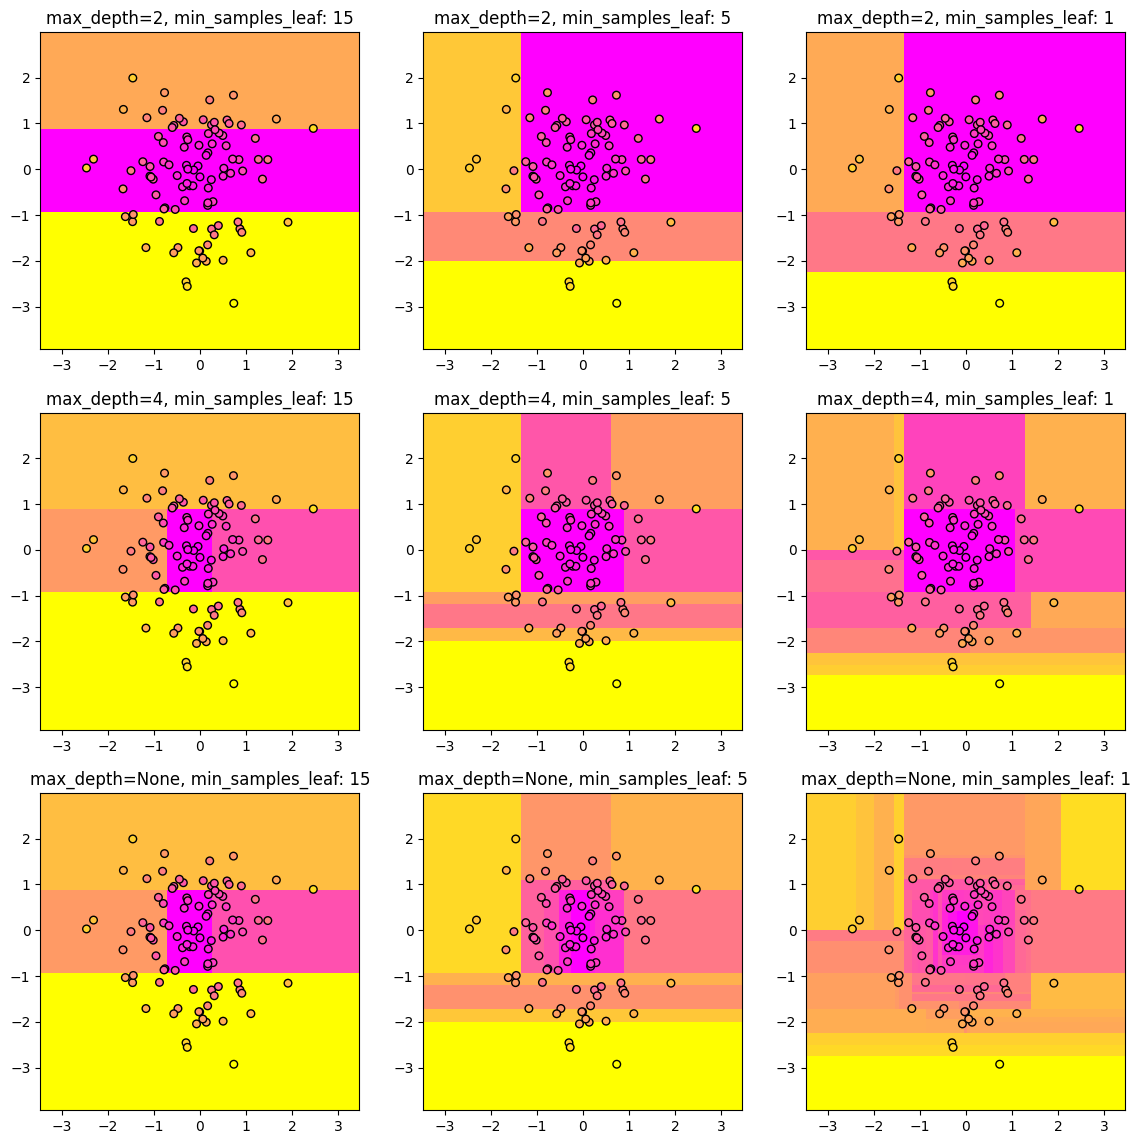

In [ ]:
plt.figure(figsize=(14, 14))

for i, max_depth in enumerate([2, 4, None]):
    for j, min_samples_leaf in enumerate([15, 5, 1]):

        clf = DecisionTreeRegressor(max_depth=max_depth, min_samples_leaf=min_samples_leaf)
        clf.fit(data_x, data_y)

        xx, yy = get_grid(data_x)
        predicted = clf.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

        plt.subplot2grid((3, 3), (i, j))
        plt.pcolormesh(xx, yy, predicted, cmap='spring')
        plt.scatter(data_x[:, 0], data_x[:, 1], c=data_y, s=30, cmap='spring', edgecolor='k')
        plt.title('max_depth=' + str(max_depth) + ', min_samples_leaf: ' + str(min_samples_leaf))

- Increasing the maximum depth and/or decreasing the minimum number of sample objects in the sheet leads to an increase in quality on the training sample and overfitting.

### Unstability of decision trees

Decision trees are algorithms that are unstable to changes in the training sample, i.e. the final classifier can change radically if the training sample changes in the slightest way.
Let's see how the tree structure will change when training on different 90% subsamples.

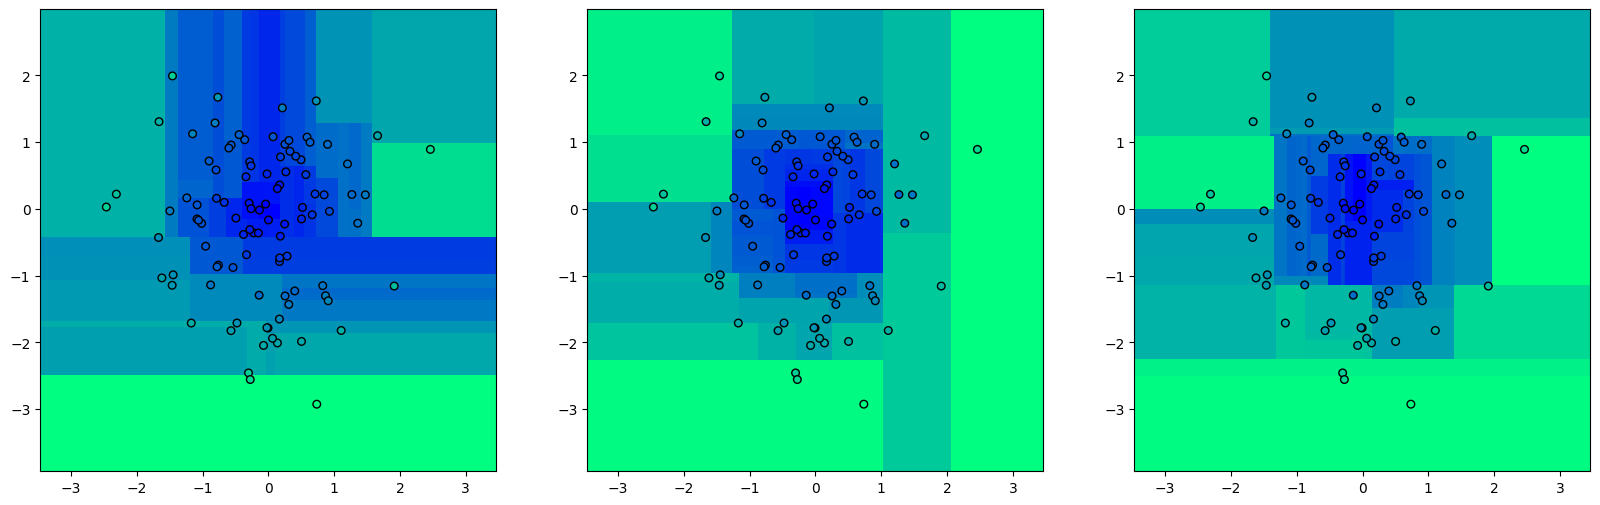

In [ ]:
plt.figure(figsize=(20, 6))

for i in range(3):
    clf = DecisionTreeRegressor(random_state=42)

    indecies = np.random.randint(data_x.shape[0], size=int(data_x.shape[0] * 0.9))
    clf.fit(data_x[indecies], data_y[indecies])

    xx, yy = get_grid(data_x)
    predicted = clf.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

    plt.subplot2grid((1, 3), (0, i))
    plt.pcolormesh(xx, yy, predicted, cmap='winter')
    plt.scatter(data_x[:, 0], data_x[:, 1], c=data_y, s=30, cmap='winter', edgecolor='k')

### Categorical features in trees

There are several approaches to working with categorical features in trees:

* One-hot encoding, Mean target encoding, binary encoding
* In some frameworks (CatBoost) the number of outgoing edges in a node can be equal not to 2, but to the number of categorical features. Thus categorical features will be taken into account naturally.

### Advantages and Disadvantages of Decision Trees:

**Advantages**
 * are well interpreted
 * easily generalized to regression and classification
 * Allow for different types of data

**Disadvantages**
 * Comparison with linear algorithms on a linearly separable sample is a fiasco.
 * Overfitting
 * Unstable to noise, sample composition, criterion

**Ways to fix the flaws**
 * Pruning
 * compositions (forests) of trees